Name: Nazmus Sakib, Student_ID: 33361881, FIT5201 - S2 2023, Assignment 1, Section 4

#Section 4 -   Logistic Regression versus Bayes Classifier

This task assesses your analytical skills. You need to study the performance of two well-known generative and probabilistic models, i.e. Bayesian classifier and logistic regression, as the size of the training set increases. Then, you show your understanding of the behavior of learning curves of typical generative and probabilistic models.

In [8]:
# Import Libraries and Dataset
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

##Question 7 [Discriminative vs Generative Models]

1. Load the breast cancer dataset via load breast cancer in sklearn.datasets, import LogisticRegression from sklearn.linear model, and copy the code from Activity 3.3. for the Bayes classifier (BC). For the Bayes classifier consider the Naive Bayes variant (without shared covariance) as well as the variants with full covariance (shared and not shared). Perform a training/test split (with train size equal to 0.8) and report which of the models performs best in terms of train and test performance.

Note: for logistic regression you can also use the code for the variant with regularisation from Activity 3.2, but this option requires a more careful calibration of the classifier parameters (batch size, max iterations and error tolerance).

In [5]:
# Load the breast cancer dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Perform a training/test split (train size = 0.8)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

# Create and train classifiers
class BayesianClassifier:

    def __init__(self, shared_cov=True, cond_ind=True):
        self.shared_cov=shared_cov
        self.cond_ind=cond_ind

    def fit(self, x, y):
        self.classes_, class_counts = np.unique(y, return_counts=True)
        self.n_ , self.p_ = x.shape
        self.k_ = len(self.classes_)
        self.cond_means_ = np.zeros(shape=(self.k_, self.p_))
        self.cond_covs_ = np.zeros(shape=(self.k_, self.p_, self.p_))

        self.class_priors_ = class_counts/len(y)
        for c in range(self.k_):
            c_rows = y==c
            self.cond_means_[c, :] = x[c_rows].mean(axis=0)
            if self.cond_ind:
                np.fill_diagonal(self.cond_covs_[c, :, :], x[c_rows].var(axis=0))
            else:
                self.cond_covs_[c, :, :] = np.cov(x[c_rows].T, bias=True)

        if self.shared_cov:
            shared_cov = np.moveaxis(self.cond_covs_, 0, -1).dot(self.class_priors_)
            self.cond_covs_[:] = shared_cov

        return self

    def predict_proba(self, x):
        m, _ = x.shape
        cond_probs = np.zeros(shape=(m, self.k_))
        for c in range(self.k_):
            # find p(x | c_k)
            # singular covariance matrices could happen (e.g., through inaccurate estimation)
            cond_probs[:, c] = multivariate_normal.pdf(x,
                                                       self.cond_means_[c],
                                                       self.cond_covs_[c],
                                                       allow_singular=True)
        # find marginal probabilities p(x) by summing all the conditionals weighted by the priors
        marginal_probs = cond_probs.dot(self.class_priors_)

        # find probability vector (p(c1 | x), ..., p(ck | x)) via p(ci | x)=p(x | ci) / p(x)
        # however, p(x) might have been rounded to 0
        # thus, compute via case distinction
        probs = np.divide((cond_probs*self.class_priors_).T,
                          marginal_probs,
                          where=marginal_probs>0, out=np.zeros(shape=(self.k_, m))).T
        return probs

    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1)

    def decision_function(self, x):
        probs = self.predict_proba(x)
        if self.k_ == 2:
            return np.log(probs[:, 1]/probs[:, 0])
        else:
            res = np.zeros(len(x), self.k_)
            for c in range(self.k_):
                res[:, c]=np.log(probs[:, c]/(1-probs[:, c]))
            return res

    def generate(self, n, c, random_state=None):
        return multivariate_normal.rvs(self.cond_means_[c], self.cond_covs_[c], size=n, random_state=random_state)


# Initialize the BayesianClassifier with different covariance options
bc_shared_cov = BayesianClassifier(shared_cov=True)
bc_non_shared_cov = BayesianClassifier(shared_cov=False)

# Train and evaluate Naive Bayes with shared covariance
bc_shared_cov.fit(X_train, y_train)
train_accuracy_nb_shared = (bc_shared_cov.predict(X_train) == y_train).mean()
test_accuracy_nb_shared = (bc_shared_cov.predict(X_test) == y_test).mean()

# Train and evaluate Naive Bayes with non-shared covariance
bc_non_shared_cov.fit(X_train, y_train)
train_accuracy_nb_non_shared = (bc_non_shared_cov.predict(X_train) == y_train).mean()
test_accuracy_nb_non_shared = (bc_non_shared_cov.predict(X_test) == y_test).mean()

# Train and evaluate Logistic Regression
logistic_reg = LogisticRegression(max_iter=10000)
logistic_reg.fit(X_train, y_train)
train_accuracy_lr = logistic_reg.score(X_train, y_train)
test_accuracy_lr = logistic_reg.score(X_test, y_test)

# Print the results
print("Train Accuracy (Naive Bayes with Shared Covariance):", train_accuracy_nb_shared)
print("Test Accuracy (Naive Bayes with Shared Covariance):", test_accuracy_nb_shared)
print("\nTrain Accuracy (Naive Bayes with Non-shared Covariance):", train_accuracy_nb_non_shared)
print("Test Accuracy (Naive Bayes with Non-shared Covariance):", test_accuracy_nb_non_shared)
print("\nTrain Accuracy (Logistic Regression):", train_accuracy_lr)
print("Test Accuracy (Logistic Regression):", test_accuracy_lr)

# Determine which model performs best
best_model = max([
    ("Naive Bayes with Shared Covariance (Train)", train_accuracy_nb_shared),
    ("Naive Bayes with Shared Covariance (Test)", test_accuracy_nb_shared),
    ("Naive Bayes with Non-shared Covariance (Train)", train_accuracy_nb_non_shared),
    ("Naive Bayes with Non-shared Covariance (Test)", test_accuracy_nb_non_shared),
    ("Logistic Regression (Train)", train_accuracy_lr),
    ("Logistic Regression (Test)", test_accuracy_lr)
], key=lambda x: x[1])

print(f"\nThe best performing model is: {best_model[0]} with an accuracy of {best_model[1]:.4f}")

Train Accuracy (Naive Bayes with Shared Covariance): 0.9406593406593406
Test Accuracy (Naive Bayes with Shared Covariance): 0.9649122807017544

Train Accuracy (Naive Bayes with Non-shared Covariance): 0.9274725274725275
Test Accuracy (Naive Bayes with Non-shared Covariance): 0.956140350877193

Train Accuracy (Logistic Regression): 0.9604395604395605
Test Accuracy (Logistic Regression): 0.956140350877193

The best performing model is: Naive Bayes with Shared Covariance (Test) with an accuracy of 0.9649


2. Implement an experiment where you test the performance for increasing training sizes of N = 5, 10, . . . , 500. For each N sample 10 training sets of the corresponding size, fit all models, and record training and test errors.
Hints: You can use training test split from sklearn.model selection with an integer parameter for train size (do not forget to use shuffle=True). Again make the repetitions the inner loop to assure that all models are trained on the same training set for a given repetition and sample size.

In [7]:
# Define a list of sample sizes from 5 to 500
sample_sizes = range(5, 501, 5)

# Define the number of repetitions
num_repetitions = 10

# Initialize lists to store results
train_errors_nb_shared = []
test_errors_nb_shared = []
train_errors_nb_non_shared = []
test_errors_nb_non_shared = []
train_errors_lr = []
test_errors_lr = []

# Loop over different sample sizes
for sample_size in sample_sizes:
    # Repeat the experiment for each sample size
    for _ in range(num_repetitions):
        # Generate a random train-test split for the current sample size
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=sample_size, random_state=42, shuffle=True)

        # Train and evaluate Naive Bayes with shared covariance
        bc_shared_cov.fit(X_train, y_train)
        train_error_nb_shared = (bc_shared_cov.predict(X_train) != y_train).mean()
        test_error_nb_shared = (bc_shared_cov.predict(X_test) != y_test).mean()
        train_errors_nb_shared.append(train_error_nb_shared)
        test_errors_nb_shared.append(test_error_nb_shared)

        # Train and evaluate Naive Bayes with non-shared covariance
        bc_non_shared_cov.fit(X_train, y_train)
        train_error_nb_non_shared = (bc_non_shared_cov.predict(X_train) != y_train).mean()
        test_error_nb_non_shared = (bc_non_shared_cov.predict(X_test) != y_test).mean()
        train_errors_nb_non_shared.append(train_error_nb_non_shared)
        test_errors_nb_non_shared.append(test_error_nb_non_shared)

        # Train and evaluate Logistic Regression
        logistic_reg = LogisticRegression(max_iter=10000)
        logistic_reg.fit(X_train, y_train)
        train_error_lr = (logistic_reg.predict(X_train) != y_train).mean()
        test_error_lr = (logistic_reg.predict(X_test) != y_test).mean()
        train_errors_lr.append(train_error_lr)
        test_errors_lr.append(test_error_lr)

# Reshape the lists to matrices for easier analysis
train_errors_nb_shared = np.array(train_errors_nb_shared).reshape(len(sample_sizes), num_repetitions)
test_errors_nb_shared = np.array(test_errors_nb_shared).reshape(len(sample_sizes), num_repetitions)
train_errors_nb_non_shared = np.array(train_errors_nb_non_shared).reshape(len(sample_sizes), num_repetitions)
test_errors_nb_non_shared = np.array(test_errors_nb_non_shared).reshape(len(sample_sizes), num_repetitions)
train_errors_lr = np.array(train_errors_lr).reshape(len(sample_sizes), num_repetitions)
test_errors_lr = np.array(test_errors_lr).reshape(len(sample_sizes), num_repetitions)

# Print important results
print("Train Errors (Naive Bayes with Shared Covariance):")
print(train_errors_nb_shared)

print("\nTest Errors (Naive Bayes with Shared Covariance):")
print(test_errors_nb_shared)

print("\nTrain Errors (Naive Bayes with Non-Shared Covariance):")
print(train_errors_nb_non_shared)

print("\nTest Errors (Naive Bayes with Non-Shared Covariance):")
print(test_errors_nb_non_shared)

print("\nTrain Errors (Logistic Regression):")
print(train_errors_lr)

print("\nTest Errors (Logistic Regression):")
print(test_errors_lr)

Train Errors (Naive Bayes with Shared Covariance):
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.1        0.1        0.1        0.1        0.1        0.1
  0.1        0.1        0.1        0.1       ]
 [0.08       0.08       0.08       0.08       0.08       0.08
  0.08       0.08       0.08       0.08      ]
 [0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
  0.06666667 0.06666667 0.06666667 0.06666667]
 [0.05714286 0.05714286 0.05714286 0.05714286 0.05714286 0.05714286
  0.05714286 0.05714286 0.05714286 0.05714286]
 [0.075      0.075      0.075      0.075      0.075      0.075
  0.075      0.075      0.075      0.075     ]
 [0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
  0

3. Create suitable plots that compare the mean train and test performances of all models as a function of training size. There is no need to include error bars if that makes the plot too hard to read.

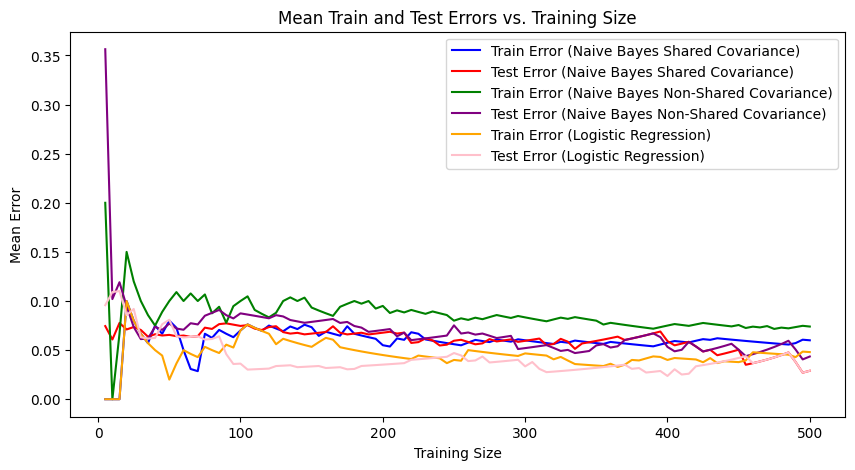

In [9]:
# Calculate mean train and test errors for each model
mean_train_errors_nb_shared = np.mean(train_errors_nb_shared, axis=1)
mean_test_errors_nb_shared = np.mean(test_errors_nb_shared, axis=1)
mean_train_errors_nb_non_shared = np.mean(train_errors_nb_non_shared, axis=1)
mean_test_errors_nb_non_shared = np.mean(test_errors_nb_non_shared, axis=1)
mean_train_errors_lr = np.mean(train_errors_lr, axis=1)
mean_test_errors_lr = np.mean(test_errors_lr, axis=1)

# Plot the mean train and test errors
plt.figure(figsize=(10, 5))
plt.plot(sample_sizes, mean_train_errors_nb_shared, label='Train Error (Naive Bayes Shared Covariance)', color='blue')
plt.plot(sample_sizes, mean_test_errors_nb_shared, label='Test Error (Naive Bayes Shared Covariance)', color='red')
plt.plot(sample_sizes, mean_train_errors_nb_non_shared, label='Train Error (Naive Bayes Non-Shared Covariance)', color='green')
plt.plot(sample_sizes, mean_test_errors_nb_non_shared, label='Test Error (Naive Bayes Non-Shared Covariance)', color='purple')
plt.plot(sample_sizes, mean_train_errors_lr, label='Train Error (Logistic Regression)', color='orange')
plt.plot(sample_sizes, mean_test_errors_lr, label='Test Error (Logistic Regression)', color='pink')

# Set labels and title
plt.xlabel('Training Size')
plt.ylabel('Mean Error')
plt.title('Mean Train and Test Errors vs. Training Size')

# Add legend
plt.legend()

# Show the plot
plt.show()

4. Formulate answers to the following questions:

  a. What happens to each classifiers train and test performance when the number of training data points is increased?

  b. Which classifier is best suited when the training set is small, and which is best suited when the training set is big?

  c. Justify your observations by providing some speculations and possible reasons. Hint: Think about model complexity and the fundamental concepts of machine learning covered in Module 1. In particular think of the number of parameters that each model has to learn and what assumptions the models make about the data which could be violated.

a. Effect of Increasing Training Data Points on Classifier Performance:

  - As the number of training data points increases, we generally expect the performance of all classifiers to improve. This is because more data provides a better representation of the underlying patterns in the data, allowing the models to learn more accurate decision boundaries.

  - Naive Bayes (Shared Covariance): This model makes strong assumptions about the data, assuming that features are conditionally independent given the class. As the training set increases, these assumptions may hold more reliably, leading to improved performance.

  - Naive Bayes (Non-Shared Covariance): This variant relaxes the conditional independence assumption. With more data, it has the potential to capture more complex relationships, potentially leading to better performance.

  - Logistic Regression: With more data, logistic regression has the opportunity to learn more complex decision boundaries. However, it's important to consider the impact of model complexity and potential overfitting, especially if the number of features is high.

b. Best Classifier for Small vs. Big Training Sets:

  - Small Training Set: When the training set is small, simpler models with fewer parameters and assumptions may perform better. This is because they are less likely to overfit to the limited training data. Therefore, the Naive Bayes classifier (either variant) may be more suited for small training sets due to its simplicity.

  - Big Training Set: As the training set becomes larger, more complex models like Logistic Regression have the potential to capture intricate relationships in the data. They can better utilize the abundance of information available. Therefore, Logistic Regression may be more suited for larger training sets.

c. Justification:

  - Model Complexity: Naive Bayes makes strong assumptions about the data (conditional independence), which may not hold in real-world scenarios. As the training set grows, these assumptions may become more reliable, benefiting Naive Bayes. Logistic Regression, being more flexible, can better adapt to complex relationships but may overfit with small datasets.

  - Number of Parameters: Naive Bayes has fewer parameters to learn compared to Logistic Regression. With a small training set, having fewer parameters can help prevent overfitting. However, with a large training set, Logistic Regression can effectively utilize its larger parameter space.

  - Assumptions: Naive Bayes assumes conditional independence, which may be violated in practice. The non-shared covariance variant relaxes this assumption, potentially performing better with more data. Logistic Regression makes fewer strict assumptions about the data.

  - Overfitting: With a small training set, complex models like Logistic Regression may overfit, capturing noise in the data. Naive Bayes, with its simpler structure, is less prone to overfitting in such scenarios.

  - Underfitting: Conversely, with a large training set, Naive Bayes may suffer from underfitting due to its simple structure, while Logistic Regression can effectively capture more complex patterns.

These observations emphasize the importance of considering both the model complexity and the size of the training set when choosing a classifier. It's a trade-off between model flexibility and the amount of available training data.